# Sort spikes and make bout/motif rasters
For every run in the session:
 - Load the recordings
 - Get the sync events for the nidq, ap, lf sync channels -> to npy for further synching 
 - Sort spikes
 - Get the bouts/mots and align them to the ap_0 time scalem
 - make and view some 'bout rasters'
 

Assumes that preprocessing has occured:
- sglx_preprocess:
    - extraction of microphone streams
    - bout detections
- curate_bouts-bird-plotly-ephys:
    - manual curation of detected bouts

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)


os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["KILOSORT3_PATH"] = '/mnt/cube/earneodo/repos/Kilosort'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'

In [2]:
import pickle
import json

In [3]:
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import oeutil as oeu
from ceciestunepipe.util import fileutil as fu

from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

In [4]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2022-09-08 13:33:20,597 root         INFO     all modules loaded


### Session parameters and raw files

In [5]:
reload(et)

bird = 's_b1555_22'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [6]:
reload(et)
reload(oeu)
sess_par = {'bird': bird,
           'sess': '2022-08-17',
           'probe': 'probe_0',
           'sort': 'sort_2'}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'], ephys_software='oe')

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['oe']

In [7]:
raw_folder

'/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-08-17/oe'

In [8]:
sess_epochs = oeu.list_oe_epochs(exp_struct)
sess_epochs

['2022-08-17_12-38-44_550']

In [9]:
reload(et)

<module 'ceciestunepipe.file.bcistructure' from '/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/file/bcistructure.py'>

In [10]:
### pick an epoch
epoch = sess_epochs[0]
sess_par['epoch'] = epoch
oe_exp_struct = et.sgl_struct(sess_par, epoch, ephys_software='oe')

In [11]:
reload(oeu)
from spikeinterface.core import BinaryRecordingExtractor

class oeRecordingExtractor(BinaryRecordingExtractor):
    extractor_name = 'oeContinuousRecordingExtractor'
    has_default_locations = True
    installed = True  # check at class level if installed or not
    is_writable = False
    mode = 'file'
    # error message when not installed
    installation_mesg = "To use the SpikeGLXRecordingExtractor run:\n\n pip install mtscomp\n\n"

    _ttl_events = None  # The ttl events
    _t_0 = None # time computed naively (n/s_f_0)
    _t_prime = None # time synchronized to a pattern ('master') reference
    _s_f_0 = None # measured samplin rate (using the syn signal)
    _syn_chan_id = None # digital channel for signal id (for nidaq; automatic last channel in lf/ap streams)
    _dig = None # the digital signal
    _start_sample = None # start sample from the beginning of the run
    _start_t = None # start t (absolute in the machine)
    
    _meta_dict = None # dictionary with metadata of the recording
    _chan_pd = None # pandas dataframe with channel ids
    
    def __init__(self, rec_path: str, processor, dtype: str = 'int16', syn_chan_id=0):
        # dtype should come from the meta but for now its ok
        # rec_path is the path to the recording
        self._meta_dict = oeu.get_rec_meta(rec_path)
        self._chan_pd = oeu.build_chan_info_pd(self._meta_dict)
        self._s_f_0 = oeu.get_oe_sample_rate(self._meta_dict)
        
        cont_path = os.path.join(rec_path, 'continuous', processor, 'continuous.dat')
        
        n_chan = self._chan_pd['recorded'].sum()
        BinaryRecordingExtractor.__init__(self, cont_path, self._s_f_0, n_chan, np.int16)
        
        self._chan_names = np.array(self._chan_pd .loc[self._chan_pd ['recorded']==True, 'name'])
        
    def slice_channels(self, channels_arr):
        self._channels = list(np.array(self._channels)[channels_arr])
        self._timeseries = self._timeseries[channels_arr]
        self._chan_names = self._chan_names[channels_arr]
        
def get_oe_cont_recording(exp_struct: dict, epoch:str):
    epoch_path = exp_struct['folders']['oe']
    node_path = oeu.get_default_node(exp_struct, epoch)
    rec_path = oeu.get_default_recording(node_path)
    cont_path = oeu.get_default_continuous(rec_path)
    
    default_processor = os.path.split(cont_path)[-1]
    #print(default_processor)
    oe_recording = oeRecordingExtractor(rec_path, default_processor)
    
    return oe_recording

### load epoch files

In [12]:
epoch = sess_epochs[0]
run_recordings = {'oeb': get_oe_cont_recording(exp_struct, epoch)}
mic_file_name = os.path.join(exp_struct['folders']['derived'], epoch, 'wav_mic.wav')
mic_file_name

'/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550/wav_mic.wav'

In [13]:
### make an all_syn_dict by hand
wav_s_f, mic_stream = wavfile.read(mic_file_name, mmap=True)
all_syn_dict = {'wav': {'s_f': wav_s_f}, 
               'ap_0': {'s_f': run_recordings['oeb'].get_sampling_frequency()},
               'nidq': {'s_f': run_recordings['oeb'].get_sampling_frequency()}}

## Get the bouts
- read the curated bouts file (or a list) for the epoch
- get starts:ends in t_naive of the wav file
- get the corresponding tprimes to refer to the spikes

In [14]:
reload(et)
def bout_dict_from_pd(bout_pd: pd.DataFrame, all_syn_dict: dict) -> dict:
    s_f_wav = all_syn_dict['wav']['s_f']
    
    start_ms = bout_pd['start_ms'].values
    len_ms = bout_pd['len_ms'].values
    
    ### fill in the bout to be compatible with the boutpd from the neuropix
    # but all clocks are the same
    
    bout_dict = {
            's_f': s_f_wav, # s_f used to get the spectrogram
            's_f_nidq': all_syn_dict['nidq']['s_f'],
            's_f_ap_0': all_syn_dict['ap_0']['s_f'],
            'start_ms': start_ms,
            'len_ms': len_ms,
           'start_sample_naive': ( start_ms * s_f_wav * 0.001).astype(np.int64),
           'start_sample_nidq': ( start_ms * s_f_wav * 0.001).astype(np.int64),
            'start_sample_wav': ( start_ms * s_f_wav * 0.001).astype(np.int64),
    }
    bout_dict['start_ms_ap_0'] = start_ms
    bout_dict['start_sample_ap_0'] = bout_dict['start_sample_naive']
    
    # complete for compatibility with the sglx/neuropix datasets
    bout_pd['start_sample_ap_0'] =  bout_pd['start_sample']
    bout_pd['start_sample_naive'] =  bout_pd['start_sample']
    bout_pd['start_ms_ap_0'] = bout_pd['start_ms']
    return bout_dict


#### the bouts pandas file filtered for this session
bout_pd = et.get_epoch_bout_pd(sess_par, only_curated=True, software='oe')
bout_dict = bout_dict_from_pd(bout_pd, all_syn_dict)

2022-09-08 13:33:43,513 ceciestunepipe.file.bcistructure INFO     loading curated bouts for session 2022-08-17 from /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/bouts_oe/bout_curated.pickle
2022-09-08 13:33:48,226 ceciestunepipe.file.bcistructure INFO     Filtering bouts for epoch 2022-08-17_12-38-44_550
2022-09-08 13:33:48,358 ceciestunepipe.file.bcistructure INFO     Filtering also only manually curated bouts


In [15]:
bout_pd.head(2)

,start_ms,end_ms,start_sample,end_sample,p_step,rms_p,peak_p,bout_check,file,len_ms,...,valid_waveform,valid,spectrogram,is_call,bird,sess,epoch,start_sample_ap_0,start_sample_naive,start_ms_ap_0
0,7396079,7451694,221882370,223550820,"[65.20528215120979, 249.1892144346691, 225.527...",49.579171,491.320525,True,/mnt/sphere/speech_bci/derived_data/s_b1555_22...,55615,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,s_b1555_22,2022-08-17,2022-08-17_12-38-44_550,221882370,221882370,7396079
1,9588469,9640589,287654070,289217670,"[239.40188760006978, 311.82676549844876, 255.7...",49.579171,488.089259,True,/mnt/sphere/speech_bci/derived_data/s_b1555_22...,52120,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",False,s_b1555_22,2022-08-17,2022-08-17_12-38-44_550,287654070,287654070,9588469


In [16]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-08-17',
  'oe': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-08-17/oe',
  'kwik': '/scratch/earneodo/s_b1555_22/oe/kwik/2022-08-17',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-08-17/oe',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe',
  'tmp': '/scratch/earneodo/tmp',
  'msort': '/scratch/earneodo/s_b1555_22/oe/msort/2022-08-17',
  'ksort': '/scratch/earneodo/s_b1555_22/oe/ksort/2022-08-17/sort_2',
  'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/sort_2'},
 'files': {'par': '/scratch/earneodo/s_b1555_22/oe/ksort/2022-08-17/sort_2/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-08-17/oe/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-08-17/oe/rig.json',
  'kwd': '/scratch/earneodo/s_b1555_22/oe/kwik/2022-08-17/stream.kwd',
  'kwik': '

### Save the mot_dict data

In [17]:
bout_dict_path = os.path.join(oe_exp_struct['folders']['derived'], 'bout_dict_oe.pkl')
bout_pd_path = os.path.join(oe_exp_struct['folders']['derived'], 'bout_pd_oe.pkl')

with open(bout_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)
    
bout_pd.to_pickle(bout_pd_path)

logger.info('saved syncronized bout dict and pandas dataframe to {}, {}'.format(bout_dict_path, bout_pd_path))

2022-09-08 13:36:54,359 root         INFO     saved syncronized bout dict and pandas dataframe to /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550/bout_dict_oe.pkl, /mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550/bout_pd_oe.pkl


In [18]:
bout_dict_path

'/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550/bout_dict_oe.pkl'

## The sorting

In [19]:
import logging
import tempfile
import multiprocessing
import pickle
import os

N_JOBS_MAX = multiprocessing.cpu_count()

- invoke the recording extractor where the probe is
- quickly check data (chans look ok?)
- set parameters
- use the recording extractor and the function to sort with kilosort
- ALTERNATIVELY: do the manual curation
- Load the spikes using the functions from ceciestunepipe

##### pick one ap stream, view it after running some of the toolkits

In [20]:
ap_extractor = run_recordings['oeb']

In [21]:
ap_extractor.get_num_channels()

72

###### view it raw

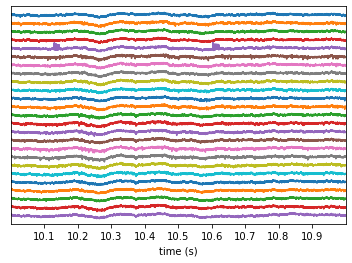

In [22]:
sw.plot_timeseries(ap_extractor, channel_ids=range(20, 45), time_range=[10,11])

###### filtered

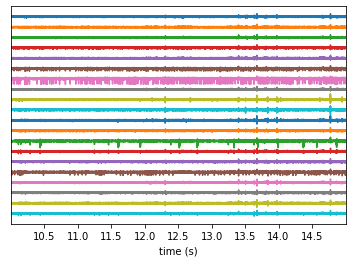

In [23]:
ap_extractor_filt = st.preprocessing.bandpass_filter(ap_extractor, freq_max=10000)
sw.plot_timeseries(ap_extractor_filt, channel_ids=range(40, 60), time_range=[10,15])

###### cmr

In [24]:
# ap_extractor_cmr = st.preprocessing.common_reference(ap_extractor)
# sw.plot_timeseries(ap_extractor_cmr, channel_ids=range(45, 55), trange=[10,15])

In [25]:
oe_exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-08-17_12-38-44_550',
 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-08-17/2022-08-17_12-38-44_550',
 'oe': '/mnt/sphere/speech_bci/raw_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550',
 'kwik': '/scratch/earneodo/s_b1555_22/oe/kwik/2022-08-17/2022-08-17_12-38-44_550',
 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550',
 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550',
 'tmp': '/scratch/earneodo/tmp/2022-08-17_12-38-44_550',
 'msort': '/scratch/earneodo/s_b1555_22/oe/msort/2022-08-17/2022-08-17_12-38-44_550',
 'ksort': '/scratch/earneodo/s_b1555_22/oe/ksort/2022-08-17/2022-08-17_12-38-44_550/sort_2',
 'sort': '/mnt/sphere/speech_bci/derived_data/s_b1555_22/2022-08-17/oe/2022-08-17_12-38-44_550/sort_2'}

In [26]:
def run_spikesort(recording_extractor: BinaryRecordingExtractor, 
                  logger: logging.Logger,
                  sort_pickle_path: str,
                  tmp_dir: str, 
                  grouping_property: str=None,
                 sorting_method: str='kilosort3',
                 n_jobs_bin: int=N_JOBS_MAX,
                 chunk_mb: int=8192, restrict_to_gpu=None,
                 **sort_kwargs):

    logger.info("Grouping property: {}".format(grouping_property))
    logger.info("sorting method: {}".format(sorting_method))
    
    # try:
    if sorting_method == "kilosort2":
        # perform kilosort sorting
        sort_tmp_dir = os.path.join(tmp_dir, 'tmp_ks2')
        logger.info('Sorting tmp dir {}'.format(sort_tmp_dir))
        
        if restrict_to_gpu is not None:
            logger.info('Will set visible gpu devices {}'.format(restrict_to_gpu))
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
            os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(restrict_to_gpu)

            
        sort = ss.run_kilosort2(
            recording_extractor,
            car=True,
            output_folder=sort_tmp_dir,
            parallel=True,
            verbose=True,
            grouping_property=grouping_property,
            chunk_mb=chunk_mb,
            n_jobs_bin=n_jobs_bin,
            **sort_kwargs
        )
    
    elif sorting_method == "kilosort3":
        # perform kilosort sorting
        sort_tmp_dir = os.path.join(tmp_dir, 'tmp_ks3')
        logger.info('Sorting tmp dir {}'.format(sort_tmp_dir))
        
        if restrict_to_gpu is not None:
            logger.info('Will set visible gpu devices {}'.format(restrict_to_gpu))
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
            os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(restrict_to_gpu)
            
        sort = ss.run_kilosort3(
            recording_extractor,
            car=True,
            output_folder=sort_tmp_dir,
            #parallel=True,
            verbose=True,
            #grouping_property=grouping_property,
            #chunk_mb=chunk_mb,
            **sort_kwargs
        )
        
    else:
        raise NotImplementedError('Only know how to sort kilosort2/3 for now, \
                                        will deal with {} later'.format(sorting_method))
        
    logger.info('done sorting')
    
    # save sort
    logger.info("Saving sort {}".format(sort_pickle_path))
    with open(sort_pickle_path, "wb") as output:
        pickle.dump(sort, output, pickle.HIGHEST_PROTOCOL)
    logger.info("Sorting output saved to {}".format(sort_pickle_path))
      
#     # get templates and max channel
#     logger.info("Getting templates")
#     templates = st.postprocessing.get_unit_templates(
#         recording_extractor,
#         sort,
#         max_spikes_per_unit=200,
#         save_as_property=True,
#         verbose=True,
#         n_jobs=n_jobs_bin,
#         grouping_property=grouping_property,
#     )
    
#     logger.info("Getting main channel")
#     max_chan = st.postprocessing.get_unit_max_channels(
#         recording_extractor, 
#         sort, 
#         save_as_property=True, 
#         verbose=True, 
#         n_jobs=n_jobs_bin
#     )   
    
    # save sort again with all that processed data
    sort_temp_pickle_path = sort_pickle_path + '.dump.pkl'
    logger.info("Saving sort {}".format(sort_temp_pickle_path))
    sort.dump_to_pickle(sort_temp_pickle_path)
    
    return sort

In [27]:
# ks_params = {'kilo_version': 2,
#              'use_gpu': 1,
#             'auto_merge': 1,
#             'filt_per_chan': 4,
#             's_f': int(s_f),
#             'spkTh': -4,
#             'minFR': 1/100,
#             }

In [28]:
default_ks3_params = ss.Kilosort3Sorter.default_params()
default_ks3_params

{'detect_threshold': 6,
 'projection_threshold': [9, 9],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.2,
 'minfr_goodchannels': 0.2,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 300,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'keep_good_only': False,
 'total_memory': '500M',
 'n_jobs_bin': 1}

### deal with the probe

In [29]:
import numpy as np
import matplotlib.pyplot as plt

from probeinterface import Probe, ProbeGroup
from probeinterface import generate_linear_probe, generate_multi_shank
from probeinterface import combine_probes
from probeinterface.plotting import plot_probe

(2, 64)


(<matplotlib.collections.PolyCollection at 0x7fd6b91d7280>, None)

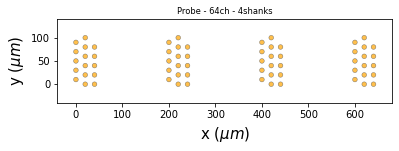

In [30]:
from ceciestunepipe.util import probemaps as pm

probe = pm.make_probes('neuronexus', 'a4x16-poly3-5mm-20s-200-160_h64_intan')
probe


good_channels = np.arange(64)

plot_probe(probe)

In [31]:
sort_rec = run_recordings['oeb'].set_probe(probe)
sort_rec.get_probe()

Probe - 64ch - 4shanks

In [33]:
#sort_rec.get_channel_locations()

##### manually enter ksort params

In [34]:
ks_params = {'minFR': 0.0001,
             'minfr_goodchannels': 0.0001}

In [35]:
tmp_loc = oe_exp_struct['folders']['ksort']
tmp_loc

'/scratch/earneodo/s_b1555_22/oe/ksort/2022-08-17/2022-08-17_12-38-44_550/sort_2'

#### run the spike sort

In [36]:
# sort_pickle_path = os.path.join(oe_exp_struct['folders']['ksort'], 'sort_ks3.pickle')

# sort = run_spikesort(sort_rec, logger, sort_pickle_path, tmp_loc, 
#                      sorting_method='kilosort3', restrict_to_gpu=1,
#                      **ks_params)

#### load the sort

In [37]:
# sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks3.pickle.dump.pkl')
# sort_pickle_path

In [38]:
#sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle.dump.pkl')
#print(sort_pickle_path)
#loaded_sort = se.load_extractor_from_pickle(sort_pickle_path)

In [39]:
### load the sort directly from kilosort npy files
from ceciestunepipe.util.spike import kilosort as ks

In [53]:
reload(ks)
sort_folder = os.path.join(oe_exp_struct['folders']['ksort'], 'tmp_ks3')
clu_df, spk_df = ks.load_spikes(sort_folder, curated=True)
spk_df.head(1)

,times,clusters,cluster_id
0,427,81,81


In [54]:
sort_folder

'/scratch/earneodo/s_b1555_22/oe/ksort/2022-08-17/2022-08-17_12-38-44_550/sort_2/tmp_ks3'

##### load spike templates raw

In [55]:
## call the HVC/RA sites
#clu_df.loc[clu_df['main_chan'].isin(hvc_chans), 'nucleus'] = 'hvc'
clu_df['nucleus'] = 'hvc'

#complete some redundancy in the spk_df
spk_df['nucelus'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['nucleus'])
spk_df['main_chan'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['main_chan'])
spk_df['kslabel'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['KSLabel'])

### save to pickle
spike_pickle_path = os.path.join(oe_exp_struct['folders']['ksort'], 'spk_df.pickle')
clu_pickle_path = os.path.join(oe_exp_struct['folders']['ksort'], 'clu_df.pickle')

spk_df.to_pickle(spike_pickle_path, protocol=4)
clu_df.to_pickle(clu_pickle_path, protocol=4)

In [56]:
clu_pickle_path

'/scratch/earneodo/s_b1555_22/oe/ksort/2022-08-17/2022-08-17_12-38-44_550/sort_2/clu_df.pickle'

In [57]:
### mark all as hvc
clu_df['nucleus'] = 'hvc'

In [58]:
clu_df.head(1)

,id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,main_chan,MSLabel,cluster_id,has_template,template,max_chans,main_7,main_wav_7,nucleus
45,76,5265.0,100.0,mua,145.162521,12,20.0,1.459165,good,17972,0,12,good,76,False,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",NaN,NaN,NaN,hvc


In [59]:
clu_df_ra = clu_df[clu_df['nucleus']=='hvc']
np.unique(clu_df_ra['cluster_id']).size

54

In [60]:
spk_df

,times,clusters,cluster_id,nucelus,main_chan,kslabel
0,427,81,81,hvc,25,mua
1,945,38,38,hvc,59,mua
2,1092,81,81,hvc,25,mua
3,1403,75,75,hvc,22,mua
4,1661,73,73,hvc,42,mua
...,...,...,...,...,...,...
2867335,369498883,75,75,hvc,22,mua
2867336,369498975,39,39,hvc,55,mua
2867337,369499059,77,77,hvc,12,mua
2867338,369499116,40,40,hvc,45,mua


#### get all features of the firing properties

In [68]:
clu_ds = clu_df.loc[50]
clu_ds

id                                                             83
Amplitude                                                  3398.6
ContamPct                                                   100.0
KSLabel                                                      good
amp                                                    137.397903
ch                                                             47
depth                                                        80.0
fr                                                       7.409165
group                                                        good
n_spikes                                                    91256
sh                                                              0
main_chan                                                      47
MSLabel                                                      good
cluster_id                                                     83
has_template                                                False
template  

{'n_spikes': 18596,
 'isi_hist': (array([177, 369, 328, 310, 360, 388, 491, 557, 540, 582, 599, 619, 605,
         551, 483]),
  array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
         26., 28., 30.])),
 'violation_fraction': 0.009518175951817595,
 'is_good': True,
 'mean_fr': 0.6618868692300798,
 'cluster_id': 58}

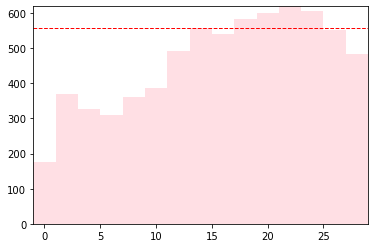

In [62]:
#### get spike features
s_f_ap = run_recordings['oeb']._s_f_0
reload(ks)
ks.get_clu_features(clu_ds, spk_df, s_f_ap, plot=True)

In [63]:
clu_feat_df = pd.DataFrame.from_dict(list(clu_df.apply(lambda ds: ks.get_clu_features(ds, spk_df, s_f_ap), 
                                                       axis=1)))
clu_feat_df.head(2)

,n_spikes,isi_hist,violation_fraction,is_good,mean_fr,cluster_id
0,17972,"([524, 508, 444, 437, 470, 492, 562, 617, 641,...",0.029156,True,0.582046,76
1,260003,"([78521, 38763, 18149, 7069, 3920, 2957, 2713,...",0.302000,False,0.046990,77


#### get all features of the spike waveform

{'main_waveform': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.16211136e-02,  2.17728950e-02,  2.18605101e-02,
         2.14895289e-02,  2.08787434e-02,  2.03517005e-02,  1.97434854e-02,
         1.86852217e-02,  1.75831635e-02,  1.63133889e-02,  1.47784082e-02,
         1.27595318e-02,  9.94386617e-03,  5.51031949e-03,  4.61343530e-04,
        -7.78896594e-03, -5.76436482e-02, -1.90786645e-01, -4.01585013e-01,
        -5.19986272e-01, -4.03954297e-01, -1.83297321e-01, -1.68392844e-02,
         7.11848959e-02,  1.11379266e-01,  1.24398001e-01,  1.22865602e-01,
         1.14966087e-01,  1.05275981e-01,  9.50755849e-02,  8.51926133e

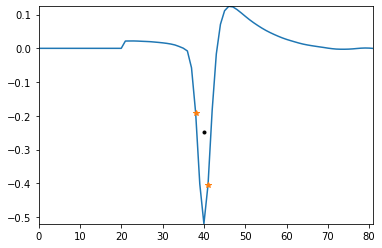

In [64]:
reload(ks)
ks.get_spk_features(clu_ds, plot=True)

In [65]:
spk_feat_df = pd.DataFrame.from_dict(list(clu_df.apply(ks.get_spk_features, axis=1)))
spk_feat_df.head(2)

IndexError: index 0 is out of bounds for axis 0 with size 0

#### append the cluster, spike waveform features to the cluster dataframe

In [64]:
clu_feat_df.merge(spk_feat_df, on='cluster_id')

,n_spikes,isi_hist,violation_fraction,is_good,mean_fr,cluster_id,main_waveform,height,left_mh_x,right_mh_x,mh_width
0,146,"([60, 1, 0, 4, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1...",0.410959,False,77.842372,32,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.077832,-1,42,43
1,25871,"([84, 519, 575, 529, 493, 446, 432, 428, 417, ...",0.003247,True,0.476083,24,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.296704,38,42,4
2,874,"([0, 0, 0, 4, 4, 7, 7, 7, 7, 10, 8, 12, 16, 14...",0.000000,True,12.091219,13,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.432961,38,42,4
3,37186,"([155, 527, 967, 1315, 1465, 1589, 1685, 1568,...",0.004168,True,0.325780,18,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.525142,38,41,3
4,566,"([2, 227, 60, 18, 8, 8, 4, 2, 2, 1, 0, 1, 1, 1...",0.003534,True,18.775675,22,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.376551,37,42,5
...,...,...,...,...,...,...,...,...,...,...,...
69,416937,"([68001, 43202, 29506, 23037, 19614, 17205, 15...",0.163097,False,0.029540,39,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.319602,38,41,3
70,143541,"([16631, 17546, 8593, 5294, 3576, 2651, 2134, ...",0.115862,False,0.085806,41,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.408332,38,41,3
71,256426,"([25244, 20217, 14755, 12744, 11382, 10481, 98...",0.098446,False,0.048032,38,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.246770,38,41,3
72,94281,"([6349, 4043, 3532, 2798, 2358, 2054, 1943, 21...",0.067341,False,0.130631,42,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.443789,38,41,3


In [65]:
clu_df = clu_df.merge(clu_feat_df, on='cluster_id').merge(spk_feat_df, on='cluster_id')

In [66]:
clu_df['mh_width_ms'] = clu_df['mh_width'] * s_f_ap * 0.001

<AxesSubplot:xlabel='mean_fr', ylabel='mh_width'>

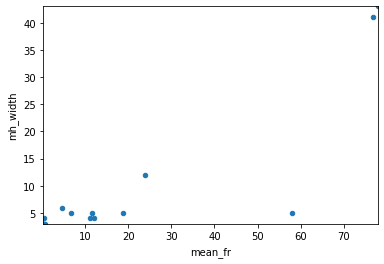

In [68]:
clu_df[clu_df['KSLabel'].isin(['good'])].plot.scatter('mean_fr', 'mh_width')

### plot a raster

### Visualize a bout together with the neural traces

In [69]:
plt.rcParams['lines.linewidth'] = 0.1
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu

In [70]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

In [71]:
from ceciestunepipe.util import wavutil as wu

In [72]:
bout_dict

{'s_f': 30000,
 's_f_nidq': 30000.0,
 's_f_ap_0': 30000.0,
 'start_ms': array([ 7396079,  9588469,  7482809,  8699234,  6309826,  6039071,
        10005551,  6188841,  8028629,  6683961,  6573616,  7173531,
         9159904,  7890864,  7048151,  6754641,  7266466, 11610796,
         7670599,  5958646,  4528748,  6481841,  7724489, 10549866,
         9347599,  7965044,  6977746,  7785329,  9948701, 11550281,
         5907571, 11303986,  7858574,  7106146,  5859571,  7617004,
         6631636,  5791111,  7158706, 11530976,  8245669,  8676424,
         6743616,  8268184,  8918739,  7038141,  7647009,  6969811,
         5834666,  7149326,  6676751,  8667909,  7349131,  6303031]),
 'len_ms': array([55615, 52120, 51495, 50660, 50430, 43845, 43745, 41935, 41795,
        41790, 41420, 40005, 38590, 37855, 37710, 37515, 37150, 36970,
        36345, 36200, 35725, 35685, 35005, 34360, 34140, 33975, 32310,
        31995, 31885, 31805, 30200, 28755, 25895, 25370, 24985, 24310,
        22595, 21885,

In [73]:
s_f_wav, mic_stream = wu.read_wav_chan(mic_file_name)

In [74]:
ap_sf = all_syn_dict['ap_0']['s_f']


### one example of bout onset

In [75]:
#hvc_chans = list(range(290, 324)) #HVC
hvc_chans = list(range(64)) #hvc
clu_df['nucleus'] = None
clu_df.loc[clu_df['main_chan'].isin(hvc_chans), 'nucleus'] = 'hvc'
#neur_chans = hvc_chans + ra_chans
neur_chans = hvc_chans

mot_idx = 0

mot_start_wav = bout_dict['start_sample_wav'][mot_idx]
mot_start_ap = bout_dict['start_sample_ap_0'][mot_idx]

pre_sec = -2.25
post_sec = 10 - pre_sec

ap_sf = all_syn_dict['ap_0']['s_f']

mic_arr = mic_stream[mot_start_wav + int(pre_sec*s_f_wav): mot_start_wav + int(post_sec*s_f_wav)]

ap_arr_arr = run_recordings['oeb'].get_traces(channel_ids=neur_chans, 
                                            start_frame=mot_start_ap + int(pre_sec*ap_sf), 
                                            end_frame=mot_start_ap + int((post_sec*ap_sf)))

<ipython-input-76-12a952a9720b>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])


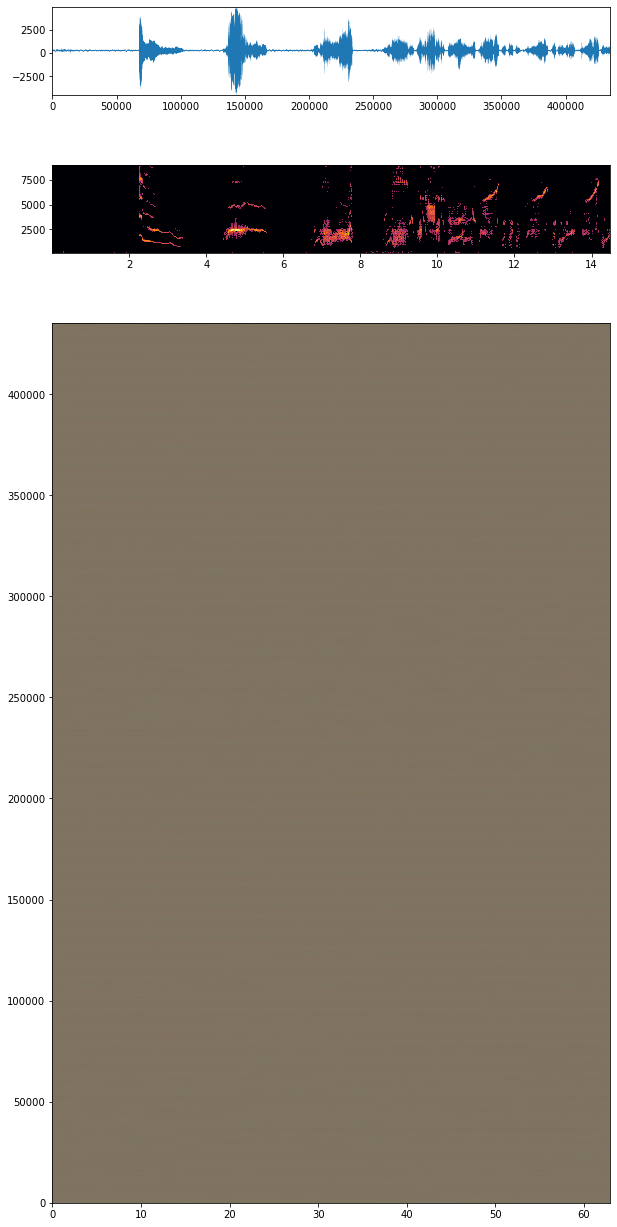

In [76]:
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f_wav)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])

### load the spikes

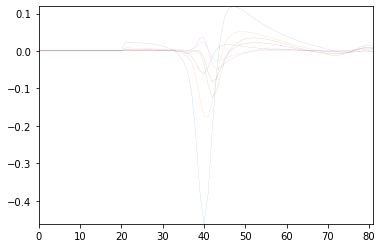

In [77]:
plt.plot(clu_df.loc[40, 'main_wav_7']);

#### check alignment of the syn signals

In [78]:
## have to do it, but it won't be like this
# n_samples_ap = run_recordings['ap_0'].get_traces().shape[-1]
# ap_syn = rsgl.ExtractDigital(run_recordings['ap_0']._raw, 0, n_samples_ap, 0, [0], run_recordings['ap_0']._meta)

# n_samples_nidq = run_recordings['nidq'].get_traces().shape[-1]
# nidq_syn= rsgl.ExtractDigital(run_recordings['nidq']._raw, 0, n_samples_nidq, 0, [0], run_recordings['nidq']._meta).flatten()

#### plot together the syn signals of the ap, nidq channels, the mic raw trace for all the motifs

In [79]:
# mot_idx = 8
# sec_before = 0
# sec_after = 10

# for mot_idx in range(2):
#     start_ap = bout_dict['start_sample_ap_0'][mot_idx] + int(run_recordings['ap_0']._s_f_0 * sec_before)
#     end_ap = bout_dict['start_sample_ap_0'][mot_idx] + int(run_recordings['ap_0']._s_f_0 * sec_after)

#     start_nidq = bout_dict['start_sample_nidq'][mot_idx] + int(run_recordings['nidq']._s_f_0 * sec_before)
#     end_nidq = bout_dict['start_sample_nidq'][mot_idx] + int(run_recordings['nidq']._s_f_0 * sec_after)

#     fig, ax = plt.subplots(nrows=2)
#     ax[0].plot(ap_syn[start_ap: end_ap], '-*')
#     ax[1].plot(nidq_syn[start_nidq: end_nidq], '-*')
#     ax[1].plot(mic_stream[0, start_nidq: end_nidq]/15000)

In [80]:
## get the actural raster for some clusters
def get_window_spikes(spk_df, clu_list, start_sample, end_sample):
    onset = start_sample
    offset = end_sample
    
    spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
    
    spk_arr = np.zeros((clu_list.size, offset - onset))

    for i, clu_id in enumerate(clu_list):
        clu_spk_t = spk_t.loc[spk_t['clusters']==clu_id, 'times'].values
        spk_arr[i, clu_spk_t - onset] = 1
    return spk_arr
    
def get_rasters(spk_df, clu_list, start_samp_arr, span_samples):
    # returns np.array([n_clu, n_sample, n_trial])
    
    # get the window spikes for all of the clusters, for each of the start_samp_arr
    spk_arr_list = [get_window_spikes(spk_df, clu_list, x, x+span_samples) for x in start_samp_arr]
    return np.stack(spk_arr_list, axis=-1)
    
#clu_list = np.array([5, 6])
#clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])
clu_list = np.unique(clu_df.loc[(clu_df['group']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

t_pre = - 15
t_post = 15

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


bout_idx = 0
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f']* t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_post)
    

spk_arr = get_window_spikes(spk_df, clu_list, start_ap , end_ap)


#rast_arr = get_rasters(spk_df, clu_list, mot_dict['start_sample_ap_0'] + t_pre_samp, t_post_samp - t_pre_samp)

<ipython-input-80-5dcea1794bab>:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


In [81]:
clu_list.size

22

In [82]:
spk_arr.shape[0]

22

<ipython-input-80-5dcea1794bab>:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
/mnt/cube/earneodo/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


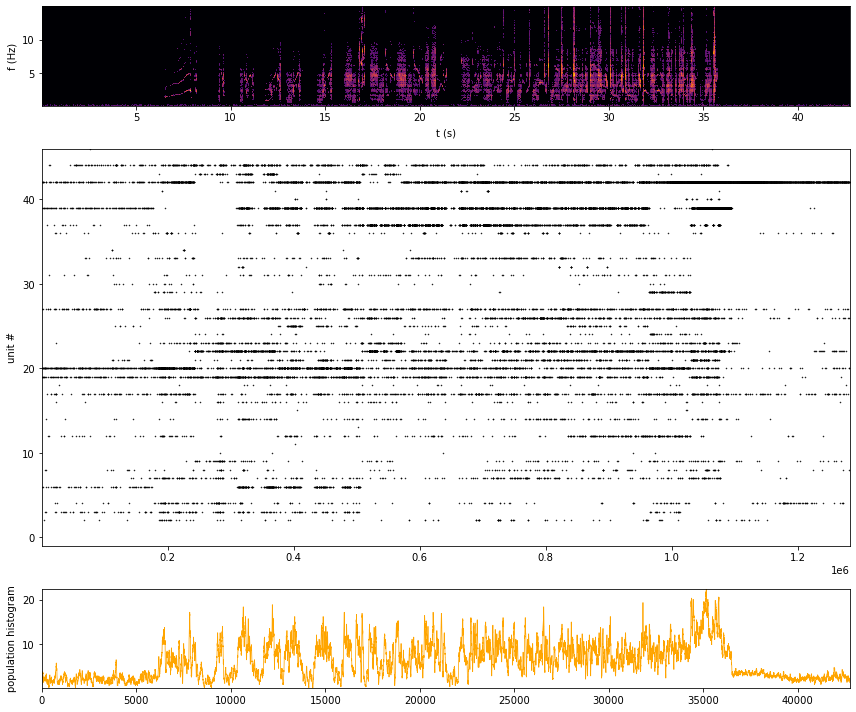

In [89]:
def plot_as_raster(x, ax=None, t_0=None):
    #x is [n_events, n_timestamps] array
    n_y, n_t = x.shape
    
    row = np.ones(n_t) + 1
    t = np.arange(n_t)
    col = np.arange(n_y)
    
    frame = col[:, np.newaxis] + row[np.newaxis, :]
    x[x==0] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    raster = ax.scatter(t * x, frame * x, marker='.', facecolor='k', s=1, rasterized=False)
    if t_0 is not None:
        ax.axvline(x=t_0, color='red')
    return ax


#### what to plot
# pick units

clu_list = np.unique(clu_df.loc[(clu_df['group'].isin(['good', 'mua'])) & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

### pick a bout
bout_idx = 31

#pick window around a bout
t_pre = - 7
t_post = bout_dict['len_ms'][bout_idx] * 0.001 - t_pre

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f']* t_post)


# get the streams/spike array
spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
mic_arr = mic_stream[start_wav: end_wav]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 4, 1]}, figsize=(12, 10))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), all_syn_dict['wav']['s_f'],
                             n_window=1024, 
                             f_max=15000,
                             cut_off=7e-7)

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f/1000, np.log(sxx), cmap='inferno')
ax[0].set_ylabel('f (Hz)')
ax[0].set_xlabel('t (s)')

#plot_as_raster(spk_arr, t_0=int(-pre_sec*s_f_ap), ax=ax[1])
plot_as_raster(spk_arr, ax=ax[1])
ax[1].set_ylim(-1, spk_arr.shape[0] + 1)
ax[1].set_ylabel('unit #')

bin_size_ms = 1
ms_gauss_kern = 50
x_kern = np.ones(ms_gauss_kern)
g_kern = 1 / np.sqrt(2 * np.pi) * np.exp(-x_kern ** 2 / 2.)
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'])
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)
psth = np.convolve(psth, g_kern, mode='same')

ax[2].plot(psth, lw=0.75, c='orange');
ax[2].set_ylabel('population histogram')

plt.tight_layout()

In [81]:
sp.ms_spectrogram?

In [76]:
from ceciestunepipe.util import plotutil as pu

In [75]:
bin_size_sample

150

In [70]:
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1_raster_sua')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

### save cluster, motif and cluster metadata

In [372]:
import pickle

In [113]:
clu_df_path = os.path.join(oe_exp_struct['folders']['derived'], 'clu_df.pkl')
clu_df.to_pickle(clu_df_path)

spk_df_path = os.path.join(oe_exp_struct['folders']['derived'], 'spk_df.pkl')
spk_df.to_pickle(spk_df_path)

mot_dict_path = os.path.join(oe_exp_struct['folders']['derived'], 'mot_dict.pkl')
with open(mot_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)


In [114]:
exp_struct['folders']['processed']

'/mnt/sphere/speech_bci/processed_data/s_b1555_22/2022-08-17/oe'

## now with the pressure

In [78]:
wu.read_wav_chan??

In [79]:
pre_chan = 2 # chans extracted in preprocessing to the wav were ['microphone_0', 'microphone_1', 'pressure']
s_f_wav, pre_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'], chan_id=pre_chan)

<ipython-input-64-5dcea1794bab>:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


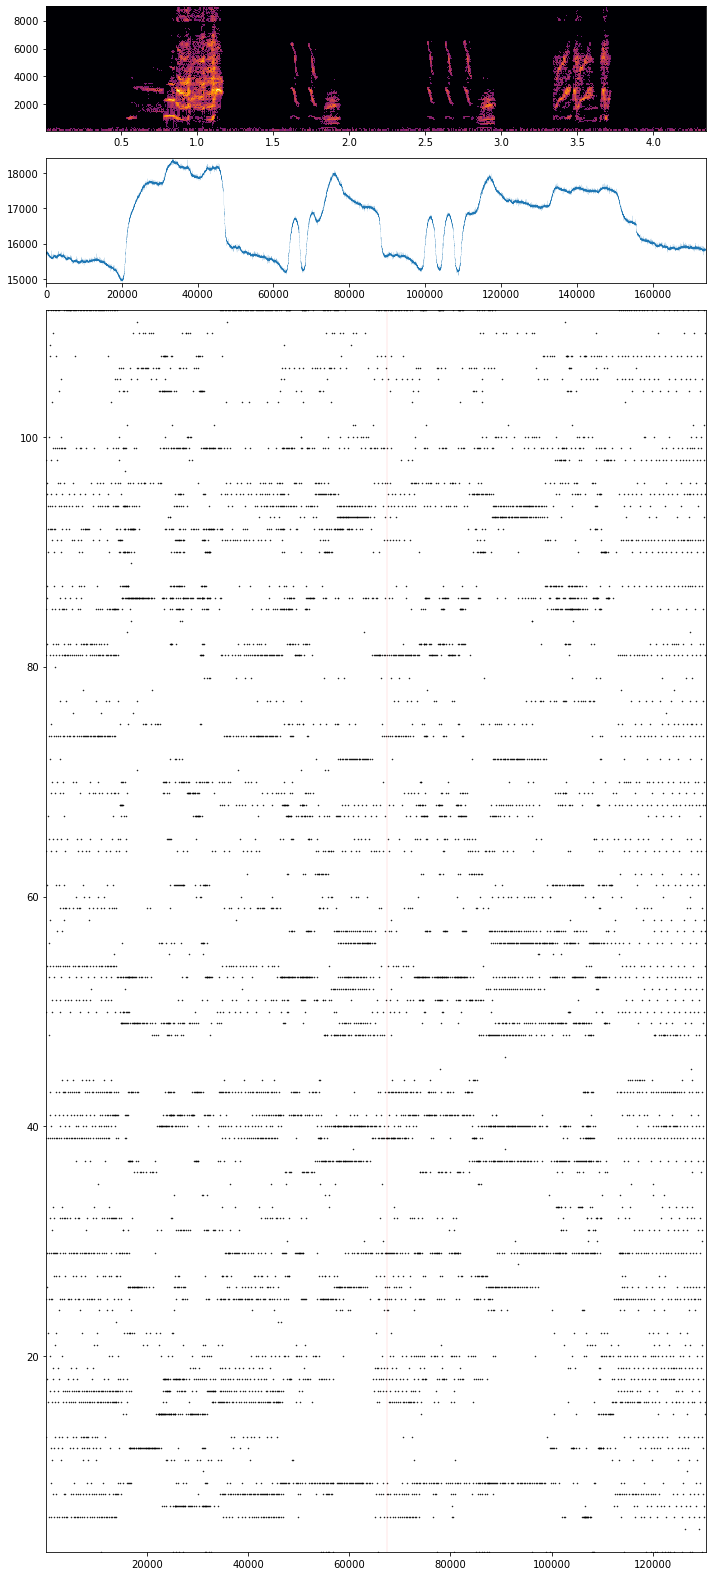

In [81]:
#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['group']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = 0.15
t_post = 4.5
t_shift = 0.15 # a time shift for the spike array

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)
t_shift_samp = int(t_shift * s_f_ap)

##Pick a bout
bout_idx = 0
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f']* t_post)


# get the streams/spike array
spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
# a shifted spike array
spk_arr_shift = get_window_spikes(spk_df, clu_list, int(start_ap) + t_shift_samp, 
                                  int(end_ap) + t_shift_samp)

mic_arr = mic_stream[start_wav: end_wav]
pre_arr = pre_stream[start_wav: end_wav]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), all_syn_dict['wav']['s_f'])

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')
ax[1].plot(pre_arr.flatten());
plot_as_raster(spk_arr, t_0=int(-pre_sec*s_f_ap), ax=ax[2])



plt.tight_layout()

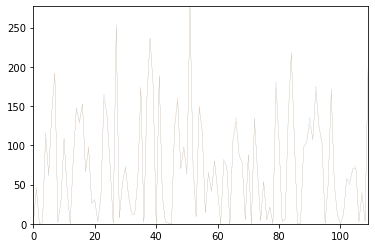

In [82]:
plt.plot(np.nansum(spk_arr, axis=1))
plt.plot(np.nansum(spk_arr_shift, axis=1))

In [83]:
spk_arr.shape

(110, 130500)

In [84]:
spk_arr_shift.shape

(110, 130500)

### GPFA/PCA

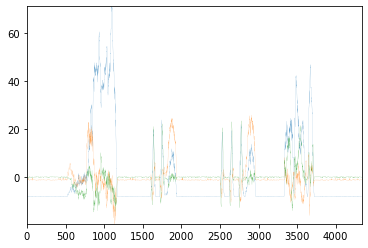

In [85]:
###PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=3, svd_solver='full')
sxx_pc = pca.fit_transform(np.log(sxx.T))
plt.plot(sxx_pc)

###GPFA

In [86]:
import neo

def spike_trains_from_spk_arr(spk_arr, s_f=30000):
    # get the time of the spikes
    # make a neo SpikeTrain for each cluster
    t_stop = spk_arr.shape[1]/s_f
    spk_train_list = [neo.SpikeTrain(times=np.where(x==1)[0]/s_f, units='sec', t_stop=t_stop) for x in spk_arr]
    
    return spk_train_list

    
bout_spk_trains = spike_trains_from_spk_arr(spk_arr)
bout_spk_trains_shift = spike_trains_from_spk_arr(spk_arr_shift)

spk_trains_list = [bout_spk_trains, bout_spk_trains_shift]

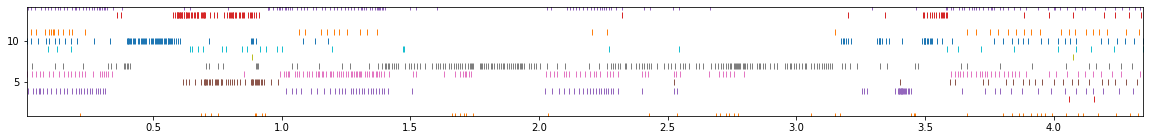

In [87]:
fig, ax = plt.subplots(figsize=(20, 2))

for i, spiketrain in enumerate(bout_spk_trains_shift[:15]):
    ax.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

In [88]:
import quantities as pq
from elephant.gpfa import GPFA
import viziphant as vp

# specify fitting parameters
bin_size = 15 * pq.ms

latent_dimensionality = 6

gpfa_2dim = GPFA(bin_size=bin_size, x_dim=latent_dimensionality)

In [89]:
gpfa_2dim.fit(spk_trains_list)
print(gpfa_2dim.params_estimated.keys())

Initializing parameters using factor analysis...

Fitting GPFA model...
dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes'])


In [90]:
trajectories_list = gpfa_2dim.transform(spk_trains_list)

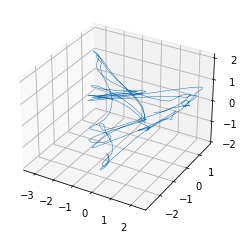

In [91]:
### plot a single one
i_bout = 0
single_trial_trajectory = trajectories_list[0]
shifted_trial_trajectory = trajectories_list[1]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(single_trial_trajectory[0], single_trial_trajectory[1], single_trial_trajectory[2], '-', lw=0.5)

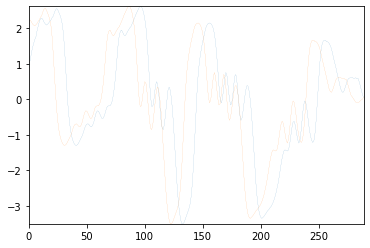

In [92]:
plt.plot(single_trial_trajectory[0])
plt.plot(shifted_trial_trajectory[0])

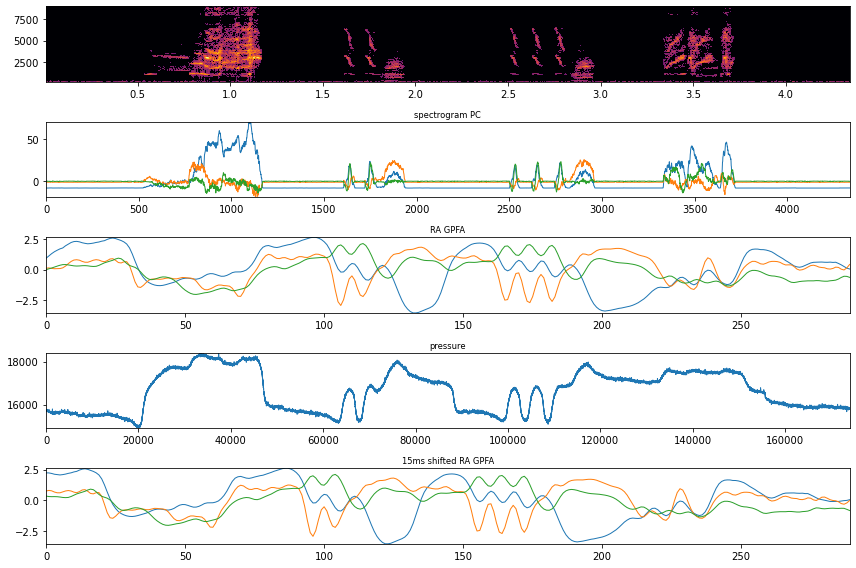

In [93]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12, 8))

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

ax[1].set_title('spectrogram PC')
ax[1].plot(sxx_pc, lw=1);

ax[2].set_title('RA GPFA')
ax[2].plot(single_trial_trajectory[:3].T, lw=1);

ax[3].set_title('pressure')
ax[3].plot(pre_arr, lw=1);

ax[4].set_title('15ms shifted RA GPFA')
ax[4].plot(shifted_trial_trajectory[:3].T, lw=1);
plt.tight_layout()

### Todo
- classify the neurons as contribuiting more or less to predicting the pressure trace. 
        -One approach is a neuron dropping curve, where the measure of the contribution is the correlation of the gpfa with the pressure.
        - Another approach is to do a multivariate regression with the rates, and pick the neurons that contribute the most (higher weights).
        - Something more sophisticated?
        - Once that is done, what do the GPFA of one set and the complement look like? Likely we want to assess the contributions with one different method than the GPFA, and that should corroborate the previous result.

In [94]:
single_trial_trajectory.shape

(6, 290)

In [101]:
np.pi

3.141592653589793

In [140]:
from scipy.spatial import distance
from itertools import combinations

def angular_spread(x):
    # the angular span relative to the generalized 45 degree direction
    ref = np.ones_like(x )
    
    #cos_
    return distance.cosine(x - np.min(x), ref)

def component_spread(x):
    all_pairs = np.array(list(combinations(x, 2)))
    #print(all_pairs)
    all_segments = np.diff(all_pairs, axis=1)
    return np.linalg.norm(all_segments)

# apply to all of the bouts
gpf_span = np.array([component_spread(i[:2]) for i in single_trial_trajectory.T])

gpf_span_2 = np.array([component_spread(i[1:3]) for i in single_trial_trajectory.T])

component_spread([-1, 1, 1])

2.8284271247461903

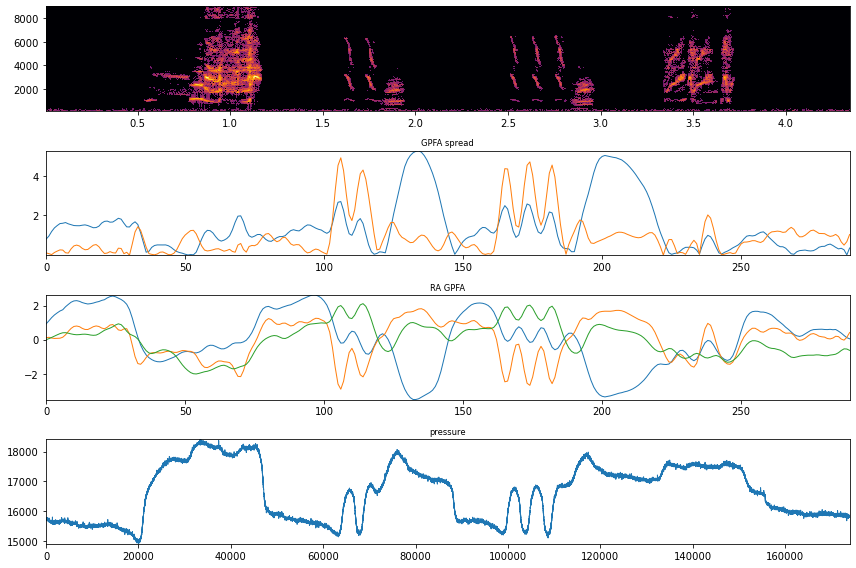

In [141]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 8))

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

ax[1].set_title('GPFA spread')
ax[1].plot(gpf_span, lw=1);
ax[1].plot(gpf_span_2, lw=1);

ax[2].set_title('RA GPFA')
ax[2].plot(single_trial_trajectory[:3].T, lw=1);

ax[3].set_title('pressure')
ax[3].plot(pre_arr, lw=1);

plt.tight_layout()

### The similarities

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# for one against all
def cosine_norm(x, y):
    cos_arr = cosine_similarity(x, y)
    cos_norm = np.linalg.norm(np.diagonal(cos_arr))
    return cos_norm

def cosine_sum(x, y):
    cos_arr = cosine_similarity(x, y)
    cos_norm = np.trace(cos_arr)
    return cos_norm

def distance_to_others(bout_df, i_bout, feature='spec_pc_chop'):
    
    one_series = bout_df.iloc[i_bout][feature]
    
    distances = bout_df[feature].apply(lambda x: cosine_similarity(one_series, x))
    return distances

def all_dist_array(bout_df, feature):
    dist_list = [distance_to_others(bout_df, i, feature) for i in bout_df.index]
    return np.vstack(dist_list)

In [ ]:
self_milarities_list = [cosine_similarity(x, x) for x in [sxx_pc, single_trial_trajectory[:3].T]]

In [ ]:
plt.imshow(self_milarities_list[0])

In [ ]:
plt.imshow(self_milarities_list[1])

In [ ]:
from scipy import spatial

spatial.distance.cosine(pre_arr, pre_arr)

In [ ]:
from scipy.signal import correlate

In [ ]:
plt.plot(correlate(pre_arr, pre_arr))

In [ ]:
plt.plot(pre)